In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
from torch import nn
from torch import Tensor
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from collections import OrderedDict
from typing import Optional
from tqdm.auto import tqdm

from utils.vit_utils import ViT # 이전 장의 image embedding

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
batch_size = 16
n_valid = 0.3

In [3]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT 모델 입력 크기
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_train = len(trainset)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(trainset, 
                         batch_size=batch_size, 
                         sampler = train_sampler,
                         num_workers=1)

valid_loader = DataLoader(trainset,
                          batch_size = batch_size,
                          sampler = valid_sampler,
                          num_workers = 1)

test_loader = DataLoader(testset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=1)


Files already downloaded and verified
Files already downloaded and verified


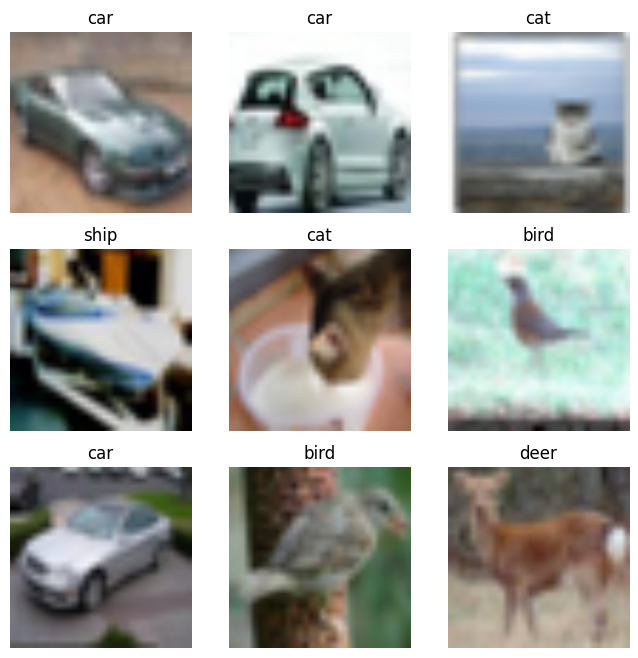

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow((rearrange(((img*0.5)+0.5)*255, 'c h w -> h w c')).type(torch.uint16))
plt.show()

In [5]:
model = ViT(img_size = [3, 224, 224],
                patch_size=16,
                embedding_size = 768,
                depth= 12,
                n_classes = 10,
                reduce_type = None)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


In [6]:
n_epochs = 5 

valid_loss_min = np.Inf

train_loss_list = []
valid_loss_list = []

for epoch in tqdm(range(1, n_epochs+1)):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

  0%|          | 0/625 [00:02<?, ?it/s]

Test Loss: 1.988806

Test Accuracy of plane: 51% (511/1000)
Test Accuracy of   car: 59% (590/1000)
Test Accuracy of  bird: 48% (484/1000)
Test Accuracy of   cat: 42% (422/1000)
Test Accuracy of  deer: 17% (173/1000)
Test Accuracy of   dog: 23% (235/1000)
Test Accuracy of  frog: 52% (528/1000)
Test Accuracy of horse: 44% (446/1000)
Test Accuracy of  ship: 72% (723/1000)
Test Accuracy of truck: 54% (549/1000)

Test Accuracy (Overall): 46% (4661/10000)
